In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
from glob import glob
import sys
import gsw as gsw
import copy as copy
import matplotlib as mpl
def modtime(H):
    try:
        datetimeindex = H.indexes['Time'].to_datetimeindex()
        H['Time']=datetimeindex
    except:
        datetimeindex = H.indexes['time'].to_datetimeindex()
        H['time']=datetimeindex
        
    return H

In [2]:
data_loc = '/net/bgr/Work/Tropics_Paper/Paper/Data'
LES0 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))
LES3 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_3N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))

LES0_1h = LES0.resample(time='1H').interpolate(kind="linear")
LES3_1h = LES3.resample(time='1H').interpolate(kind="linear")

rho0=LES0.rho0.values
alpha = LES0.alpha.values
beta = LES0.beta.values


/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to 

In [3]:
MOM0 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_RH18_0.nc').isel(xh=0,yh=0,xq=0).squeeze())
MOM3 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_RH18_3.nc').isel(xh=0,yh=0,xq=0).squeeze())

MOM0_1 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_cap_0.nc').isel(xh=0,yh=0,xq=0).squeeze())
MOM3_1 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_cap_3.nc').isel(xh=0,yh=0,xq=0).squeeze())

MOM0_2 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_GLS_0.nc').isel(xh=0,yh=0,xq=0).squeeze())
MOM3_2 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_GLS_3.nc').isel(xh=0,yh=0,xq=0).squeeze())




/tmp/ipykernel_3730922/2925081973.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()
/tmp/ipykernel_3730922/2925081973.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()
/tmp/ipykernel_3730922/2925081973.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time betwe

In [4]:
def group_detrended_hour(data1h,Z='z'):
    FLD=np.zeros([24,data1h[Z].size])
    FLDdt=np.zeros([24,data1h[Z].size])

    for ii in range(24):
        UP = (data1h.time.size//24)*24
        HRs = data1h.isel(time=range(ii,UP,24))

        FLD[ii,:]=HRs.mean(dim='time').values
    for ii in range(data1h[Z].size):
        FLDdt[:,ii]=FLD[:,ii]-np.arange(0.5,24)*(FLD[-1,ii]-FLD[0,ii])/24
    return FLDdt



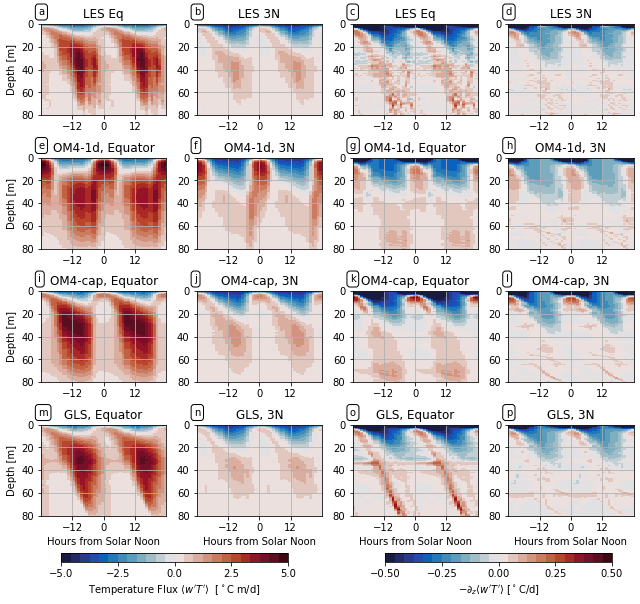

In [5]:
cmap1=cmocean.cm.balance
levels1=np.linspace(-1e-4,1e-4,25)
levels1=np.linspace(-0.5,0.5,25)

cmap2=cmocean.cm.balance
levels2=np.linspace(-1e-5,1e-5,25)
levels2=np.linspace(-5,5,25)

f,a=plt.subplots(4,4,figsize=(9,8))

LES_DAT=(-LES0_1h.tempw+LES0_1h.kappadtdz)*86400

FLDdt = group_detrended_hour(LES_DAT)
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)

fld=(FLDdt[xi,:]).T

ax=a.ravel()[0]
C1=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('LES Eq')
ax.set_ylabel('Depth [m]')

FLDdt = group_detrended_hour(MOM0.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[4]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d, Equator')
ax.set_ylabel('Depth [m]')

FLDdt = group_detrended_hour(MOM0_1.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[8]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-cap, Equator')
ax.set_ylabel('Depth [m]')

FLDdt = group_detrended_hour(MOM0_2.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[12]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('GLS, Equator')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hours from Solar Noon')

LES_DAT=(-LES3_1h.tempw+LES3_1h.kappadtdz)*86400

FLDdt = group_detrended_hour(LES_DAT)
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)

fld=(FLDdt[xi,:]).T

ax=a.ravel()[1]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES3_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('LES 3N')

FLDdt = group_detrended_hour(MOM3.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[5]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d, 3N')

FLDdt = group_detrended_hour(MOM3_1.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[9]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-cap, 3N')

FLDdt = group_detrended_hour(MOM3_2.Tflx_dia_diff,Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[13]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('GLS, 3N')
ax.set_xlabel('Hours from Solar Noon')

#LES_DAT=(-LES0_1h.tempw+LES0_1h.kappadtdz)
LES_DAT=(-LES0_1h.tempw+LES0_1h.kappadtdz).differentiate(coord='z')*86400

FLDdt = group_detrended_hour(LES_DAT)
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)

fld=(FLDdt[xi,:]).T

ax=a.ravel()[2]
C2=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('LES Eq')

FLDdt = group_detrended_hour(-(MOM0.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[6]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d, Equator')

FLDdt = group_detrended_hour(-(MOM0_1.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[10]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-cap, Equator')

FLDdt = group_detrended_hour(-(MOM0_2.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[14]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('GLS, Equator')
ax.set_xlabel('Hours from Solar Noon')

LES_DAT=(-LES3_1h.tempw+LES3_1h.kappadtdz).differentiate(coord='z')*86400

FLDdt = group_detrended_hour(LES_DAT)
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)

fld=(FLDdt[xi,:]).T

ax=a.ravel()[3]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES3_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('LES 3N')

FLDdt = group_detrended_hour(-(MOM3.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[7]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d, 3N')

FLDdt = group_detrended_hour(-(MOM3_1.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[11]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-cap, 3N')

FLDdt = group_detrended_hour(-(MOM3_2.Tflx_dia_diff.differentiate(coord='zi')),Z='zi')*86400
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[15]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('GLS, 3N')
ax.set_xlabel('Hours from Solar Noon')

f.tight_layout()

f.subplots_adjust(bottom=0.1)



cbar_ax = f.add_axes([0.1, 0.02, 0.35, 0.015])
cb=f.colorbar(C1, cax=cbar_ax,orientation='horizontal')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Temperature Flux $\left<w^\prime T^\prime \right>$  [$^\circ$C m/d]')
# cb.ax.set(yticks=cb.get_ticks(),yticklabels=lbls)
cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])

cbar_ax = f.add_axes([0.6, 0.02, 0.35, 0.015])
cb=f.colorbar(C2, cax=cbar_ax,orientation='horizontal')
cb.set_label(r'$-\partial_z \left<w^\prime T^\prime \right>$ [$^\circ$C/d]')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
#cb.ax.set(xticks=cb.get_ticks(),xticklabels=lbls)
cb.ax.set_xticks(ticks=[-0.5,-0.25,0,0.25,0.5])

for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    a.ravel()[AXi].text(-25,-8,txt,bbox=dict(boxstyle='round', facecolor='white'))
    
f.savefig('../Fig/LES-MOM1d-dTdt_and_heatflux_diurnalcomposite.png',dpi=200,bbox_inches = "tight")